/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Test files 7558
🔍 Ejecutando inferencia...
7557/7558
📉 Generando matriz de confusión...


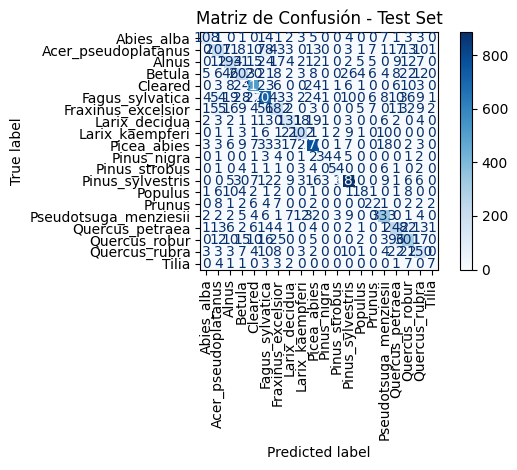


📋 Reporte de clasificación:
                       precision    recall  f1-score   support

           Abies_alba       0.83      0.71      0.76       153
  Acer_pseudoplatanus       0.52      0.49      0.50       426
                Alnus       0.57      0.55      0.56       352
               Betula       0.52      0.50      0.51       404
              Cleared       0.81      0.82      0.81       634
      Fagus_sylvatica       0.68      0.72      0.69       984
   Fraxinus_excelsior       0.50      0.46      0.48       394
        Larix_decidua       0.64      0.64      0.64       206
      Larix_kaempferi       0.80      0.78      0.79       260
          Picea_abies       0.81      0.87      0.84       890
          Pinus_nigra       0.81      0.59      0.68        58
        Pinus_strobus       0.82      0.69      0.75        78
     Pinus_sylvestris       0.90      0.89      0.90       995
              Populus       0.46      0.32      0.38        56
               Prunus    

In [1]:
import os
import json
import re
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# -----------------------------
# Configuración
# -----------------------------
MODEL_PATH = "/kaggle/input/treetecmodels/resnet18_transfer_10_epochs.pth"
TXT_PATH = "/kaggle/input/treetecmodels/test_files.txt"
IMG_DIR = "/kaggle/input/treesattfg/Images/Images"
SPECIES_JSON = "/kaggle/input/treesattfg/species_list.json"

# -----------------------------
# Cargar lista de especies
# -----------------------------
with open(SPECIES_JSON, 'r') as f:
    species_list = json.load(f)

species_to_idx = {s: i for i, s in enumerate(species_list)}

# -----------------------------
# Extraer especie desde nombre de archivo
# -----------------------------
def extract_species(filename):
    basename = os.path.basename(filename).replace(".tif", "")
    parts = basename.split('_')
    species_parts = []
    for part in parts:
        if part.isdigit():
            break
        species_parts.append(part)
    species = "_".join(species_parts)
    species = species.replace("_spec.", "").replace(".", "")  # limpiar "spec." y puntos
    return species


# -----------------------------
# Transformaciones
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# -----------------------------
# Cargar modelo
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(species_list)
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

# -----------------------------
# Leer archivos de test
# -----------------------------
with open(TXT_PATH, 'r') as f:
    test_filenames = [line.strip() for line in f.readlines()]

print("Test files",len(test_filenames))
# -----------------------------
# Inferencia
# -----------------------------
true_labels = []
pred_labels = []

print("🔍 Ejecutando inferencia...")
test_len = len(test_filenames)
j = 0
for filename in test_filenames:
    print(f"{j}/{test_len}", end="\r", flush=True)
    filepath = None
    for root, _, files in os.walk(IMG_DIR):
        if filename in files:
            filepath = os.path.join(root, filename)
            break

    if filepath is None:
        print(f"⚠️ Archivo no encontrado: {filename}")
        continue

    true_species = extract_species(filename)
    if true_species not in species_to_idx:
        print(f"⚠️ Especie desconocida: {true_species} en archivo {filename}")
        continue

    true_idx = species_to_idx[true_species]
    

    image = Image.open(filepath).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        pred_idx = output.argmax(1).item()
    
    true_labels.append(true_idx)
    pred_labels.append(pred_idx)

    j +=1



# -----------------------------
# Matriz de confusión
# -----------------------------
print("\n📉 Generando matriz de confusión...")
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=species_list)
disp.plot(cmap='Blues', xticks_rotation=90)
plt.title("Matriz de Confusión - Test Set")
plt.tight_layout()
plt.show()

# -----------------------------
# Reporte de clasificación
# -----------------------------
print("\n📋 Reporte de clasificación:")
print(classification_report(true_labels, pred_labels, target_names=species_list, zero_division=0))
